In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math as math
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from time import time
from tqdm import tqdm
from collections import Counter

In [4]:
batch_size = 256

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, 10)
        )

    def forward(self, x):
        return self.linear(x)

In [6]:
class classicRbf():

    def __init__(self, train_data, train_labels):
        self.means, self.radii = self.initialization(train_data, train_labels)
        
    def initialization(self, train_data, train_labels):
        means = []
        radii = []
        for i in np.unique(train_labels):
            data_i = train_data[train_labels == i]
            m = np.mean(data_i, axis=0)
            means.append(m)
    
            dist = 0
            for d in data_i:
                if np.linalg.norm(m - d) > dist:
                   dist = np.linalg.norm(m - d)
            radii.append(dist)
        means = np.column_stack(means)
        means = means.T
        return means, radii

    def transform_gauss(self, X): #Gaussian RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.exp(-np.linalg.norm(data - self.means[i])**2 / self.radii[i]**2) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

    def transform_multi(self, X): # Multiquadric RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.sqrt((self.radii[i]**2 + np.linalg.norm(data - self.means[i])**2) / self.radii[i]) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

In [7]:
train_data, train_labels = next(iter(train))
train_data = np.array(train_data).reshape(-1, 3*32*32)
train_data = train_data / 255.0
train_labels = np.array(train_labels).astype(int)

test_data, test_labels = next(iter(test))
test_data = np.array(test_data).reshape(-1, 3*32*32)
test_data = test_data / 255.0
test_labels = np.array(test_labels).astype(int)

start_time = time()
classic = classicRbf(train_data, train_labels)
new_samples_train = classic.transform_gauss(train_data)
new_samples_test = classic.transform_gauss(test_data)
print(f"Transform Time = {time() - start_time} seconds")

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size = 256

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform Time = 8.287991285324097 seconds


In [8]:
def batch_gd(train_loader, test_loader, model, device, num_epochs=40, epoch_update=5, learning_rate=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, mode='max')
    criterion = nn.CrossEntropyLoss()
    test_acc = 0


    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % epoch_update == 0:
            print(f'Epoch [{epoch + 1} / {num_epochs}], loss {loss.item():.4f}')
            model.eval()
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for data, labels in train_loader:
                    data = data.to(device)
                    labels = labels.to(device)
                    outputs = model(data)

                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
                acc = 100.0 * n_correct / n_samples
                print(f'Training Accuracy of the network: {acc} %')
                n_correct = 0
                n_samples = 0
                for data, labels in test_loader:
                    data = data.to(device)
                    labels = labels.to(device)
                    outputs = model(data)

                    _, predicted = torch.max(outputs, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
                test_acc = 100.0 * n_correct / n_samples
                print(f'Testing accuracy of the network: {test_acc} %')
                scheduler.step(acc)
                model.train()
    return test_acc

In [156]:
start_time = time()
model = SimpleMLP(10)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2663
Training Accuracy of the network: 14.124 %
Accuracy of the network: 13.84 %
Epoch [10 / 40], loss 2.2527
Training Accuracy of the network: 18.112 %
Accuracy of the network: 17.86 %
Epoch [15 / 40], loss 2.2295
Training Accuracy of the network: 20.182 %
Accuracy of the network: 20.25 %
Epoch [20 / 40], loss 2.2436
Training Accuracy of the network: 19.536 %
Accuracy of the network: 19.33 %
Epoch [25 / 40], loss 2.2024
Training Accuracy of the network: 22.91 %
Accuracy of the network: 23.24 %
Epoch [30 / 40], loss 2.1927
Training Accuracy of the network: 21.618 %
Accuracy of the network: 21.74 %
Epoch [35 / 40], loss 2.2201
Training Accuracy of the network: 21.62 %
Accuracy of the network: 21.73 %
Epoch [40 / 40], loss 2.2112
Training Accuracy of the network: 21.538 %
Accuracy of the network: 21.72 %
MLP Training time = 34.376468658447266 seconds


In [157]:
start_time = time()
new_samples_train = classic.transform_multi(train_data)
new_samples_test = classic.transform_multi(test_data)
print(f"Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform Time = 9.152508020401001 seconds


In [186]:
start_time = time()
model = SimpleMLP(10)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2957
Training Accuracy of the network: 12.104 %
Accuracy of the network: 11.75 %
Epoch [10 / 40], loss 2.2946
Training Accuracy of the network: 15.388 %
Accuracy of the network: 15.23 %
Epoch [15 / 40], loss 2.2914
Training Accuracy of the network: 15.004 %
Accuracy of the network: 15.17 %
Epoch [20 / 40], loss 2.2786
Training Accuracy of the network: 16.596 %
Accuracy of the network: 17.2 %
Epoch [25 / 40], loss 2.2822
Training Accuracy of the network: 16.976 %
Accuracy of the network: 17.22 %
Epoch [30 / 40], loss 2.2802
Training Accuracy of the network: 18.82 %
Accuracy of the network: 19.35 %
Epoch [35 / 40], loss 2.2729
Training Accuracy of the network: 19.148 %
Accuracy of the network: 19.78 %
Epoch [40 / 40], loss 2.2699
Training Accuracy of the network: 18.648 %
Accuracy of the network: 19.47 %
MLP Training time = 36.4974889755249 seconds


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

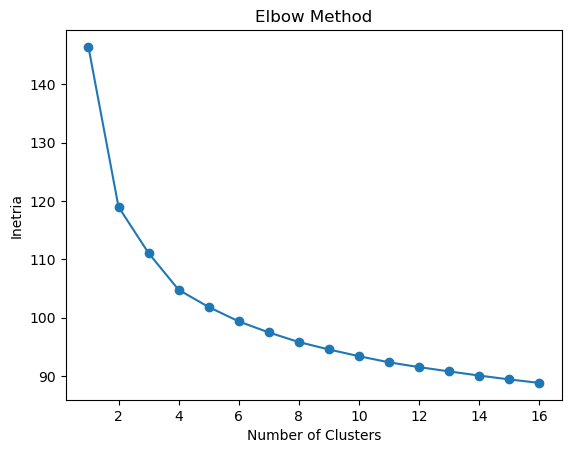

In [13]:
max_clusters = 16

inertia = []
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inetria')
plt.show()


In [9]:
class ClassicClusterRbf():
    def __init__(self, X, n_clusters):
        self.n_clusters = n_clusters
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        rad =[]
        for i in range(self.centers.shape[0]):
            data = X[kmeans.labels_ == i]
            distances = [np.linalg.norm(x - self.centers[i]) for x in data]
            rad.append(np.max(distances))
        self.radii = rad

    def transform_gauss(self, X): #Gaussian RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.exp(-np.linalg.norm(data - self.centers[i])**2 / self.radii[i]**2) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

    def transform_multi(self, X): # Multiquadric RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.sqrt((self.radii[i]**2 + np.linalg.norm(data - self.centers[i])**2) / self.radii[i]) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

In [160]:
start_time = time()
cluster = ClassicClusterRbf(train_data, 6)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialize and Transform Time = 88.91095685958862 seconds


In [163]:
start_time = time()
model = SimpleMLP(6)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2384
Training Accuracy of the network: 16.638 %
Accuracy of the network: 16.69 %
Epoch [10 / 40], loss 2.2364
Training Accuracy of the network: 18.956 %
Accuracy of the network: 19.39 %
Epoch [15 / 40], loss 2.1655
Training Accuracy of the network: 19.75 %
Accuracy of the network: 20.07 %
Epoch [20 / 40], loss 2.1703
Training Accuracy of the network: 20.312 %
Accuracy of the network: 20.36 %
Epoch [25 / 40], loss 2.1366
Training Accuracy of the network: 21.02 %
Accuracy of the network: 21.39 %
Epoch [30 / 40], loss 2.1636
Training Accuracy of the network: 21.162 %
Accuracy of the network: 21.66 %
Epoch [35 / 40], loss 2.2158
Training Accuracy of the network: 21.234 %
Accuracy of the network: 21.74 %
Epoch [40 / 40], loss 2.2092
Training Accuracy of the network: 21.284 %
Accuracy of the network: 21.71 %
MLP training time = 35.39765000343323 seconds


In [164]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform time = 4.664383172988892 seconds


In [165]:
start_time = time()
model = SimpleMLP(6)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.3004
Training Accuracy of the network: 14.144 %
Accuracy of the network: 14.17 %
Epoch [10 / 40], loss 2.2703
Training Accuracy of the network: 16.148 %
Accuracy of the network: 16.19 %
Epoch [15 / 40], loss 2.2557
Training Accuracy of the network: 18.824 %
Accuracy of the network: 18.83 %
Epoch [20 / 40], loss 2.2228
Training Accuracy of the network: 18.882 %
Accuracy of the network: 18.85 %
Epoch [25 / 40], loss 2.2745
Training Accuracy of the network: 17.3 %
Accuracy of the network: 17.08 %
Epoch [30 / 40], loss 2.2358
Training Accuracy of the network: 18.428 %
Accuracy of the network: 18.4 %
Epoch [35 / 40], loss 2.2257
Training Accuracy of the network: 18.608 %
Accuracy of the network: 18.58 %
Epoch [40 / 40], loss 2.2396
Training Accuracy of the network: 18.574 %
Accuracy of the network: 18.55 %
MLP training time = 34.28425312042236 seconds


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

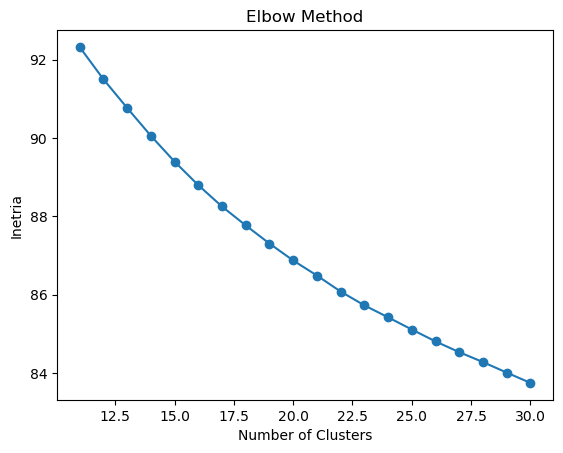

In [51]:
max_clusters = 30
start_clusters = 11

inertia = []
for n_clusters in range(start_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(start_clusters, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inetria')
plt.show()


cluster = ClassicClusterRbf(train_data, 20)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [166]:
start_time = time()
cluster = ClassicClusterRbf(train_data, 20)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialize and transform time = 322.43653869628906 seconds


In [167]:
start_time = time()
model = SimpleMLP(20)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.1974
Training Accuracy of the network: 21.788 %
Accuracy of the network: 22.17 %
Epoch [10 / 40], loss 2.1024
Training Accuracy of the network: 24.41 %
Accuracy of the network: 25.18 %
Epoch [15 / 40], loss 2.0622
Training Accuracy of the network: 25.494 %
Accuracy of the network: 26.29 %
Epoch [20 / 40], loss 1.9657
Training Accuracy of the network: 26.07 %
Accuracy of the network: 26.95 %
Epoch [25 / 40], loss 1.9391
Training Accuracy of the network: 26.372 %
Accuracy of the network: 27.3 %
Epoch [30 / 40], loss 1.9994
Training Accuracy of the network: 26.568 %
Accuracy of the network: 27.23 %
Epoch [35 / 40], loss 1.9446
Training Accuracy of the network: 26.586 %
Accuracy of the network: 27.31 %
Epoch [40 / 40], loss 2.1488
Training Accuracy of the network: 26.636 %
Accuracy of the network: 27.43 %
MLP Training time = 34.497641801834106 seconds


In [168]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform time = 15.868019104003906 seconds


In [171]:
start_time = time()
model = SimpleMLP(20)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2300
Training Accuracy of the network: 17.898 %
Accuracy of the network: 18.59 %
Epoch [10 / 40], loss 2.1642
Training Accuracy of the network: 19.538 %
Accuracy of the network: 19.7 %
Epoch [15 / 40], loss 2.2490
Training Accuracy of the network: 19.85 %
Accuracy of the network: 20.17 %
Epoch [20 / 40], loss 2.1712
Training Accuracy of the network: 22.696 %
Accuracy of the network: 22.62 %
Epoch [25 / 40], loss 2.1338
Training Accuracy of the network: 22.782 %
Accuracy of the network: 23.12 %
Epoch [30 / 40], loss 2.2695
Training Accuracy of the network: 23.32 %
Accuracy of the network: 23.76 %
Epoch [35 / 40], loss 2.1174
Training Accuracy of the network: 23.274 %
Accuracy of the network: 23.65 %
Epoch [40 / 40], loss 2.1570
Training Accuracy of the network: 23.51 %
Accuracy of the network: 23.96 %
MLP Training time = 35.518474102020264 seconds


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

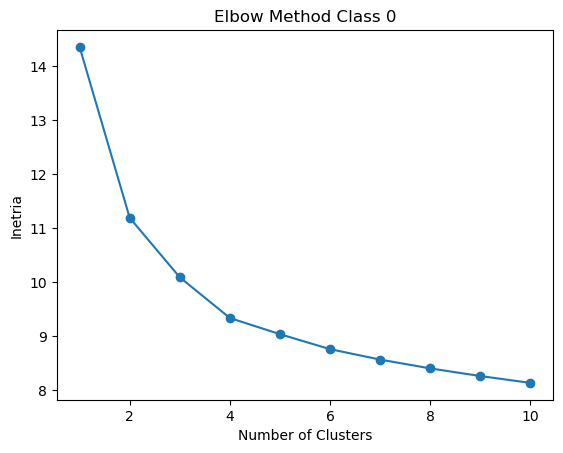

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

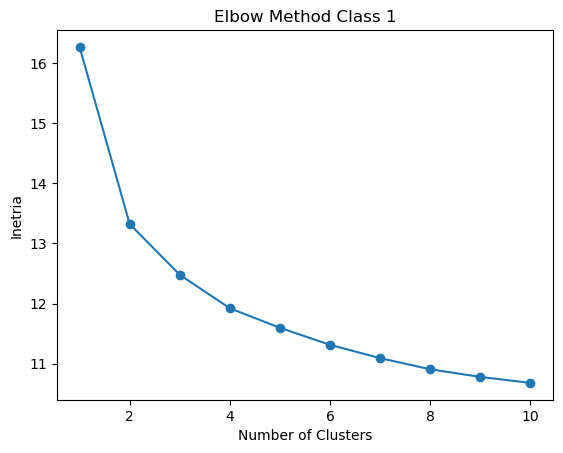

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

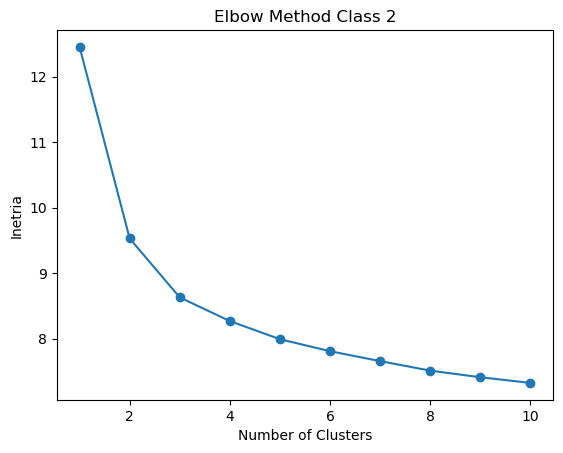

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

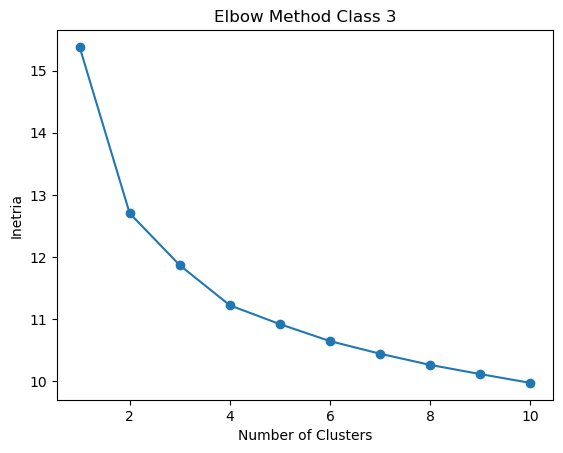

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

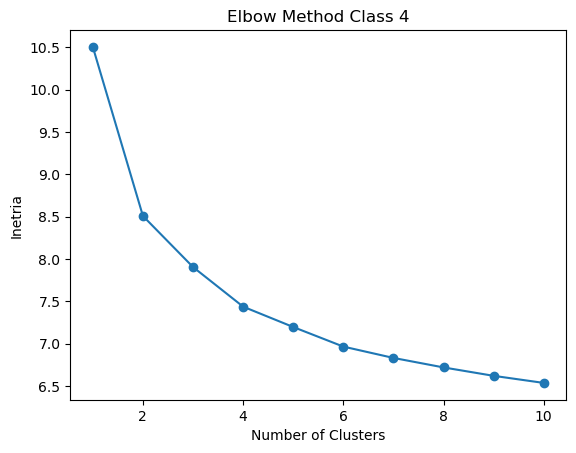

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

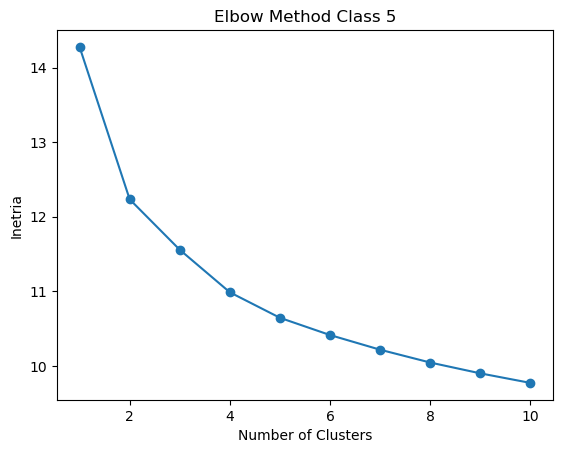

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

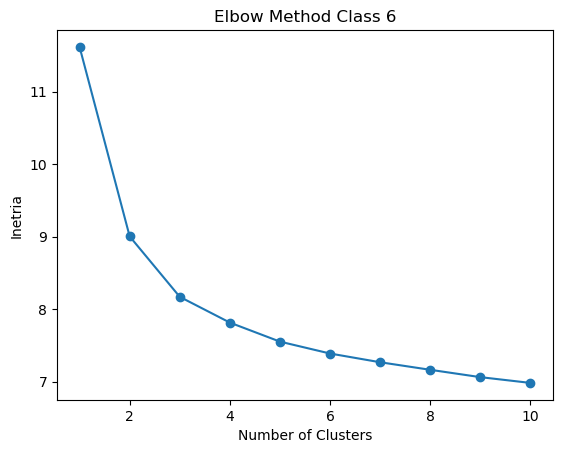

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

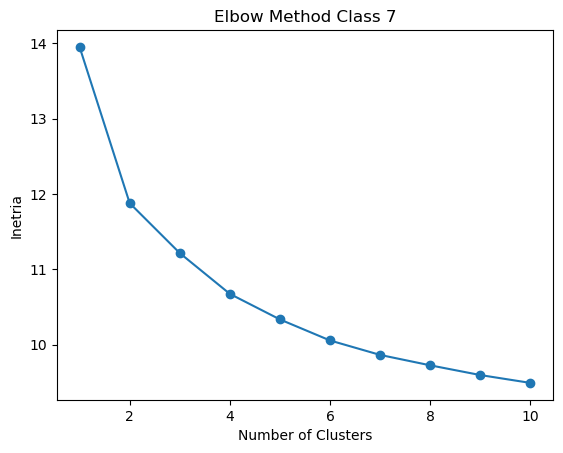

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

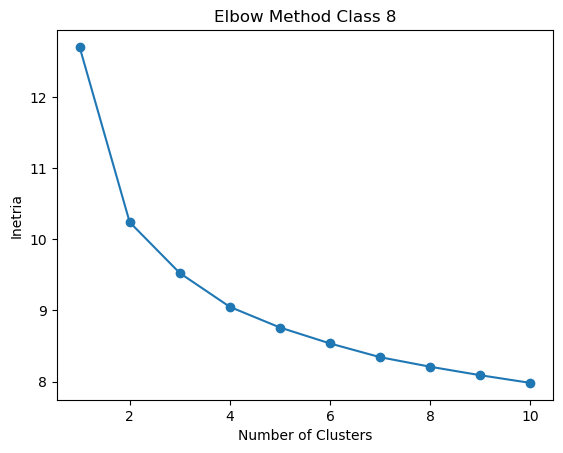

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

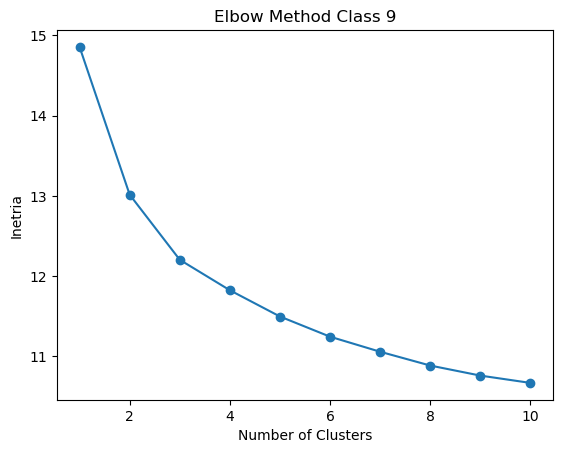

In [59]:
max_clusters = 10
for i in np.unique(train_labels):
    data = train_data[train_labels == i]
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Method Class {i}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inetria')
    plt.show()

In [10]:
class ClusterRbf():
    def __init__(self, train_data, train_labels, n_clusters):
        self.n_clusters = n_clusters
        self.centers = np.empty((0, train_data.shape[1]))  # Initialize an empty 2D array
        self.radii = []
        for i in np.unique(train_labels):
            data = train_data[train_labels == i]
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
            kmeans.fit(data)
            self.centers = np.vstack((self.centers, kmeans.cluster_centers_))  # Append new centers as rows
            for j in range(self.n_clusters):
                X = data[kmeans.labels_ == j]
                distances = [np.linalg.norm(x - self.centers[i * self.n_clusters + j]) for x in X]
                self.radii.append(np.max(distances))


    def transform_gauss(self, X): #Gaussian RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.exp(-np.linalg.norm(data - self.centers[i])**2 / self.radii[i]**2) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

    def transform_multi(self, X): # Multiquadric RBF
        new_samples = []
        for i in range(len(self.radii)):
            samples = [np.sqrt((self.radii[i]**2 + np.linalg.norm(data - self.centers[i])**2) / self.radii[i]) for data in X]
            new_samples.append(samples)
        new_samples = np.column_stack(new_samples)
        return new_samples

In [172]:
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 4)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 96.47772860527039 seconds


In [174]:
start_time = time()
model = SimpleMLP(40)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.1694
Training Accuracy of the network: 21.476 %
Accuracy of the network: 21.97 %
Epoch [10 / 40], loss 2.1824
Training Accuracy of the network: 24.388 %
Accuracy of the network: 25.1 %
Epoch [15 / 40], loss 2.1909
Training Accuracy of the network: 26.0 %
Accuracy of the network: 26.81 %
Epoch [20 / 40], loss 2.0429
Training Accuracy of the network: 26.064 %
Accuracy of the network: 27.23 %
Epoch [25 / 40], loss 2.1338
Training Accuracy of the network: 26.438 %
Accuracy of the network: 27.36 %
Epoch [30 / 40], loss 2.1038
Training Accuracy of the network: 26.758 %
Accuracy of the network: 27.72 %
Epoch [35 / 40], loss 2.0516
Training Accuracy of the network: 26.828 %
Accuracy of the network: 27.96 %
Epoch [40 / 40], loss 2.1920
Training Accuracy of the network: 26.844 %
Accuracy of the network: 27.93 %
MLP Training time = 34.16187000274658 seconds


In [176]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transforming time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transforming time = 26.97291898727417 seconds


In [180]:
start_time = time()
model = SimpleMLP(40)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2119
Training Accuracy of the network: 19.144 %
Accuracy of the network: 19.27 %
Epoch [10 / 40], loss 2.1702
Training Accuracy of the network: 18.548 %
Accuracy of the network: 19.12 %
Epoch [15 / 40], loss 2.2322
Training Accuracy of the network: 19.466 %
Accuracy of the network: 19.89 %
Epoch [20 / 40], loss 2.1461
Training Accuracy of the network: 21.506 %
Accuracy of the network: 21.67 %
Epoch [25 / 40], loss 2.1364
Training Accuracy of the network: 22.87 %
Accuracy of the network: 23.68 %
Epoch [30 / 40], loss 2.1425
Training Accuracy of the network: 23.738 %
Accuracy of the network: 24.6 %
Epoch [35 / 40], loss 2.1032
Training Accuracy of the network: 23.942 %
Accuracy of the network: 24.83 %
Epoch [40 / 40], loss 2.1012
Training Accuracy of the network: 23.828 %
Accuracy of the network: 24.67 %
MLP Training time = 35.482375621795654 seconds


In [9]:
pca = PCA(0.9, random_state=42).fit(train_data)
print(f"PCA is complete with {pca.n_components_} components")
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

PCA is complete with 99 components


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

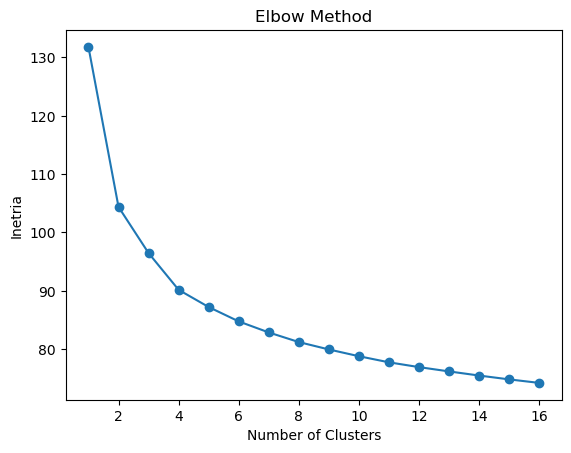

In [119]:
max_clusters = 16

inertia = []
for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inetria')
plt.show()


In [198]:
start_time = time()
classic = classicRbf(train_data, train_labels)
new_samples_train = classic.transform_gauss(train_data)
new_samples_test = classic.transform_gauss(test_data)
print(f"Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform Time = 5.8683226108551025 seconds


In [199]:
start_time = time()
model = SimpleMLP(10)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2961
Training Accuracy of the network: 9.974 %
Accuracy of the network: 9.96 %
Epoch [10 / 40], loss 2.2530
Training Accuracy of the network: 17.012 %
Accuracy of the network: 17.4 %
Epoch [15 / 40], loss 2.2409
Training Accuracy of the network: 18.656 %
Accuracy of the network: 18.5 %
Epoch [20 / 40], loss 2.2378
Training Accuracy of the network: 17.768 %
Accuracy of the network: 17.94 %
Epoch [25 / 40], loss 2.2446
Training Accuracy of the network: 21.262 %
Accuracy of the network: 21.21 %
Epoch [30 / 40], loss 2.2077
Training Accuracy of the network: 20.022 %
Accuracy of the network: 20.15 %
Epoch [35 / 40], loss 2.1950
Training Accuracy of the network: 20.168 %
Accuracy of the network: 20.13 %
Epoch [40 / 40], loss 2.2022
Training Accuracy of the network: 20.262 %
Accuracy of the network: 20.26 %
MLP Training time = 35.04612135887146 seconds


In [200]:
start_time = time()
new_samples_train = classic.transform_multi(train_data)
new_samples_test = classic.transform_multi(test_data)
print(f"Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform Time = 6.566431045532227 seconds


In [201]:
start_time = time()
model = SimpleMLP(10)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.3004
Training Accuracy of the network: 13.724 %
Accuracy of the network: 13.61 %
Epoch [10 / 40], loss 2.2920
Training Accuracy of the network: 15.494 %
Accuracy of the network: 15.6 %
Epoch [15 / 40], loss 2.2873
Training Accuracy of the network: 15.312 %
Accuracy of the network: 15.67 %
Epoch [20 / 40], loss 2.2832
Training Accuracy of the network: 18.338 %
Accuracy of the network: 18.23 %
Epoch [25 / 40], loss 2.2756
Training Accuracy of the network: 14.776 %
Accuracy of the network: 14.87 %
Epoch [30 / 40], loss 2.2762
Training Accuracy of the network: 20.278 %
Accuracy of the network: 20.12 %
Epoch [35 / 40], loss 2.2745
Training Accuracy of the network: 18.908 %
Accuracy of the network: 18.76 %
Epoch [40 / 40], loss 2.2737
Training Accuracy of the network: 19.278 %
Accuracy of the network: 19.2 %
MLP Training time = 35.13377499580383 seconds


In [202]:
start_time = time()
cluster = ClassicClusterRbf(train_data, 6)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialize and Transform Time = 5.876117944717407 seconds


In [203]:
start_time = time()
model = SimpleMLP(6)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2679
Training Accuracy of the network: 16.646 %
Accuracy of the network: 17.14 %
Epoch [10 / 40], loss 2.2334
Training Accuracy of the network: 18.438 %
Accuracy of the network: 18.94 %
Epoch [15 / 40], loss 2.2198
Training Accuracy of the network: 20.22 %
Accuracy of the network: 20.6 %
Epoch [20 / 40], loss 2.2490
Training Accuracy of the network: 20.672 %
Accuracy of the network: 21.09 %
Epoch [25 / 40], loss 2.1720
Training Accuracy of the network: 20.954 %
Accuracy of the network: 21.33 %
Epoch [30 / 40], loss 2.2034
Training Accuracy of the network: 21.072 %
Accuracy of the network: 21.6 %
Epoch [35 / 40], loss 2.1479
Training Accuracy of the network: 21.078 %
Accuracy of the network: 21.5 %
Epoch [40 / 40], loss 2.1000
Training Accuracy of the network: 21.152 %
Accuracy of the network: 21.66 %
MLP training time = 34.737327337265015 seconds


In [204]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform time = 3.884634494781494 seconds


In [205]:
start_time = time()
model = SimpleMLP(6)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2859
Training Accuracy of the network: 15.272 %
Accuracy of the network: 15.45 %
Epoch [10 / 40], loss 2.2794
Training Accuracy of the network: 16.79 %
Accuracy of the network: 16.86 %
Epoch [15 / 40], loss 2.2558
Training Accuracy of the network: 17.584 %
Accuracy of the network: 17.63 %
Epoch [20 / 40], loss 2.1901
Training Accuracy of the network: 18.138 %
Accuracy of the network: 18.22 %
Epoch [25 / 40], loss 2.2182
Training Accuracy of the network: 18.144 %
Accuracy of the network: 17.81 %
Epoch [30 / 40], loss 2.2144
Training Accuracy of the network: 18.464 %
Accuracy of the network: 18.33 %
Epoch [35 / 40], loss 2.2743
Training Accuracy of the network: 18.414 %
Accuracy of the network: 18.38 %
Epoch [40 / 40], loss 2.2581
Training Accuracy of the network: 18.434 %
Accuracy of the network: 18.45 %
MLP training time = 34.68007469177246 seconds


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

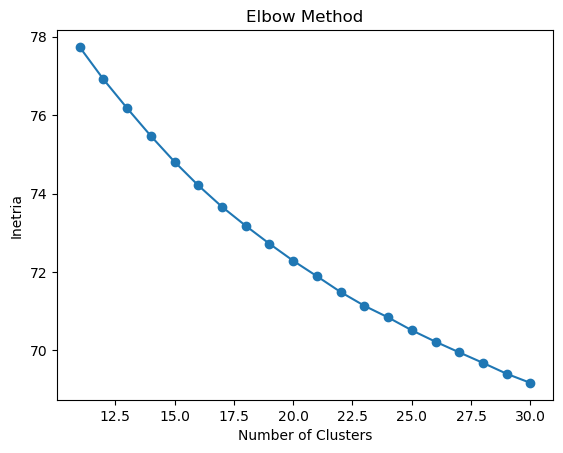

In [128]:
max_clusters = 30
start_clusters = 11

inertia = []
for n_clusters in range(start_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(start_clusters, max_clusters + 1), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inetria')
plt.show()


In [206]:
start_time = time()
cluster = ClassicClusterRbf(train_data, 20)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialize and transform time = 20.372685194015503 seconds


In [207]:
start_time = time()
model = SimpleMLP(20)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.1661
Training Accuracy of the network: 23.072 %
Accuracy of the network: 23.55 %
Epoch [10 / 40], loss 2.2264
Training Accuracy of the network: 24.71 %
Accuracy of the network: 25.15 %
Epoch [15 / 40], loss 2.1482
Training Accuracy of the network: 25.578 %
Accuracy of the network: 26.27 %
Epoch [20 / 40], loss 2.0313
Training Accuracy of the network: 26.126 %
Accuracy of the network: 27.04 %
Epoch [25 / 40], loss 2.1049
Training Accuracy of the network: 26.492 %
Accuracy of the network: 27.27 %
Epoch [30 / 40], loss 2.1132
Training Accuracy of the network: 26.608 %
Accuracy of the network: 27.28 %
Epoch [35 / 40], loss 2.0366
Training Accuracy of the network: 26.618 %
Accuracy of the network: 27.25 %
Epoch [40 / 40], loss 1.9768
Training Accuracy of the network: 26.674 %
Accuracy of the network: 27.26 %
MLP Training time = 35.20143365859985 seconds


In [208]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform time = 13.222578763961792 seconds


In [209]:
start_time = time()
model = SimpleMLP(20)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2616
Training Accuracy of the network: 18.256 %
Accuracy of the network: 18.3 %
Epoch [10 / 40], loss 2.1677
Training Accuracy of the network: 21.336 %
Accuracy of the network: 21.94 %
Epoch [15 / 40], loss 2.2261
Training Accuracy of the network: 21.446 %
Accuracy of the network: 21.66 %
Epoch [20 / 40], loss 2.1792
Training Accuracy of the network: 22.432 %
Accuracy of the network: 22.82 %
Epoch [25 / 40], loss 2.1630
Training Accuracy of the network: 22.984 %
Accuracy of the network: 23.38 %
Epoch [30 / 40], loss 2.1540
Training Accuracy of the network: 23.592 %
Accuracy of the network: 24.29 %
Epoch [35 / 40], loss 2.2009
Training Accuracy of the network: 23.812 %
Accuracy of the network: 24.41 %
Epoch [40 / 40], loss 2.1808
Training Accuracy of the network: 23.458 %
Accuracy of the network: 24.03 %
MLP Training time = 34.721304416656494 seconds


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

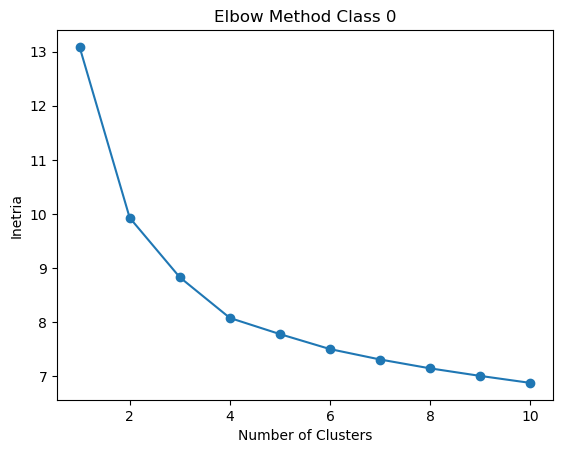

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

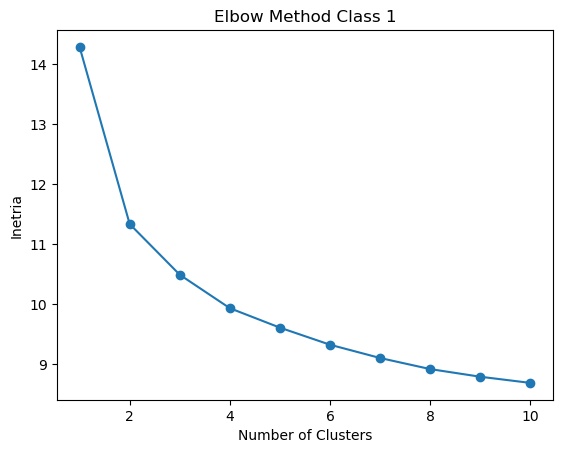

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

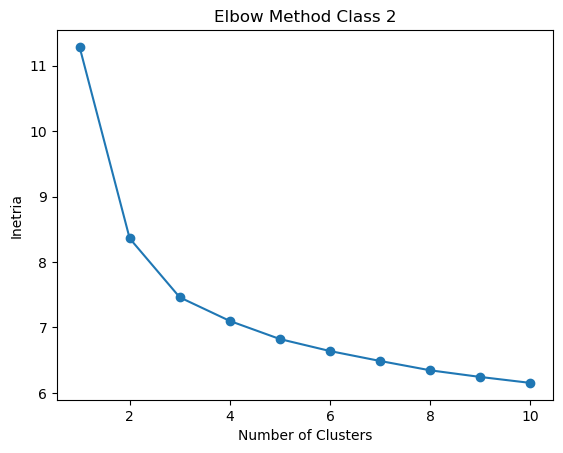

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

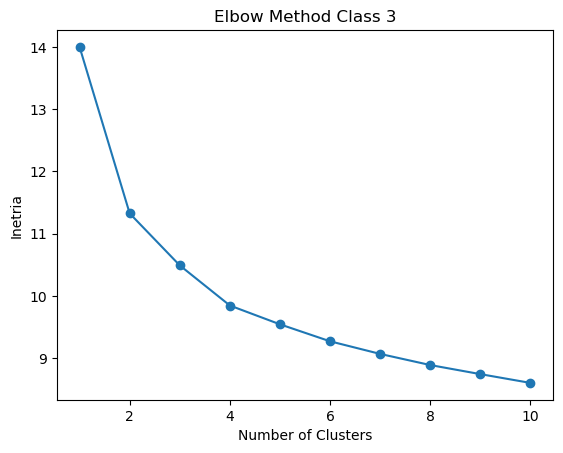

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

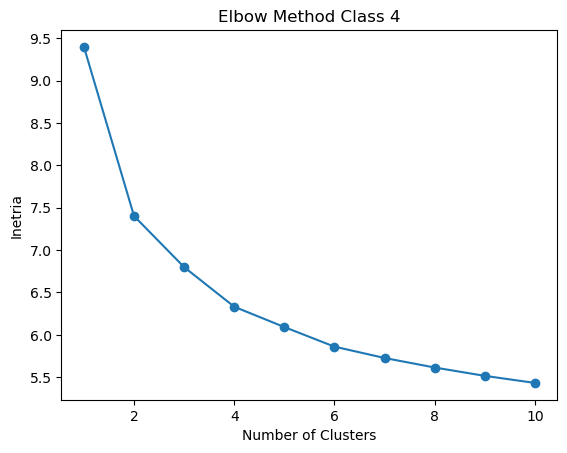

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

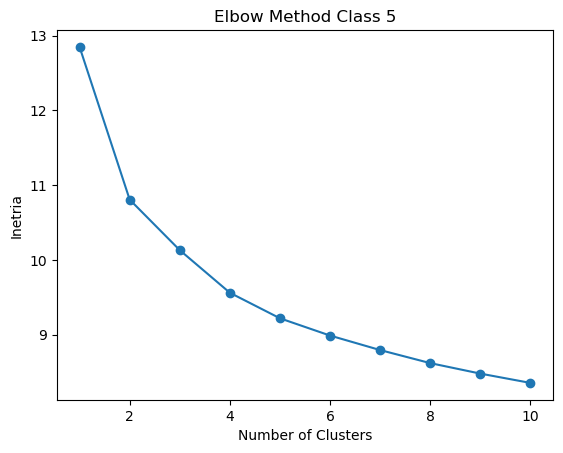

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

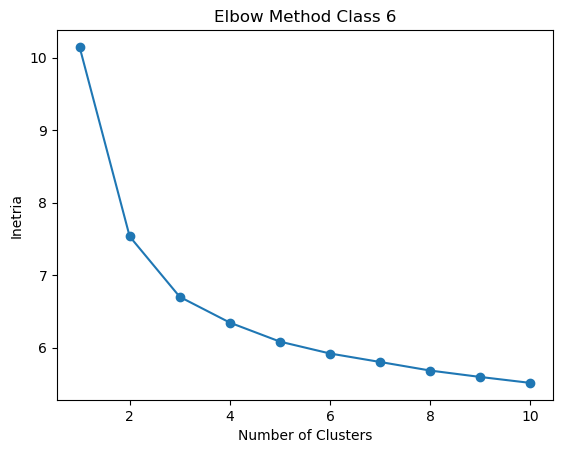

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

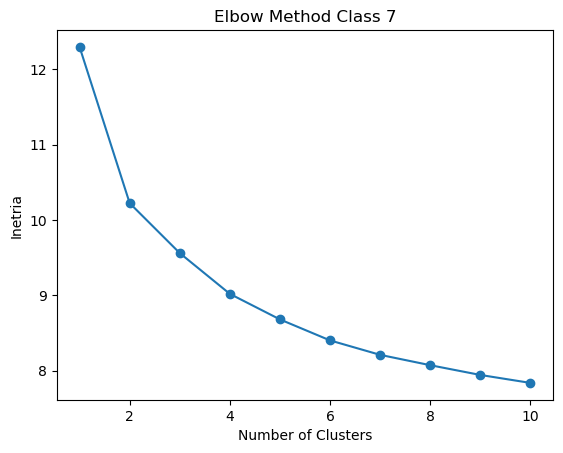

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

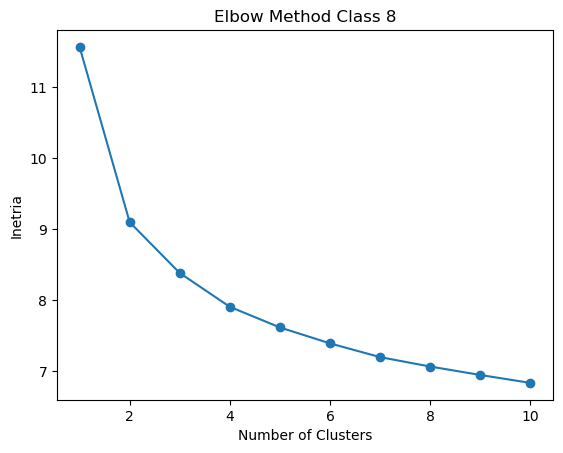

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

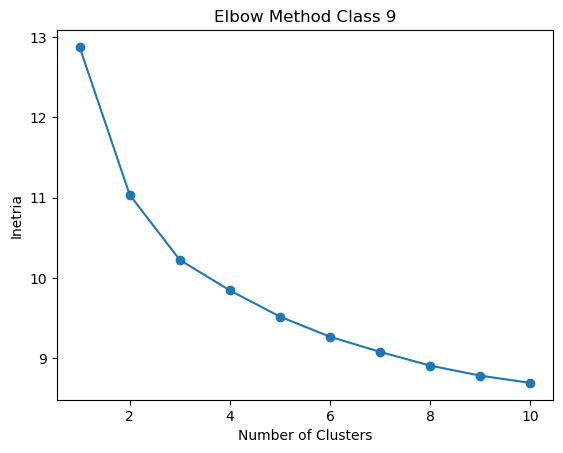

In [135]:
max_clusters = 10
for i in np.unique(train_labels):
    data = train_data[train_labels == i]
    inertia = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title(f'Elbow Method Class {i}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inetria')
    plt.show()

In [213]:
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 4)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 17.610369443893433 seconds


In [215]:
start_time = time()
model = SimpleMLP(40)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.2255
Training Accuracy of the network: 21.052 %
Accuracy of the network: 21.56 %
Epoch [10 / 40], loss 2.1142
Training Accuracy of the network: 24.744 %
Accuracy of the network: 25.13 %
Epoch [15 / 40], loss 2.0803
Training Accuracy of the network: 25.042 %
Accuracy of the network: 25.69 %
Epoch [20 / 40], loss 1.9804
Training Accuracy of the network: 26.326 %
Accuracy of the network: 27.17 %
Epoch [25 / 40], loss 1.9890
Training Accuracy of the network: 26.74 %
Accuracy of the network: 27.8 %
Epoch [30 / 40], loss 2.1733
Training Accuracy of the network: 26.716 %
Accuracy of the network: 27.77 %
Epoch [35 / 40], loss 2.0909
Training Accuracy of the network: 26.846 %
Accuracy of the network: 27.91 %
Epoch [40 / 40], loss 2.0517
Training Accuracy of the network: 26.824 %
Accuracy of the network: 27.82 %
MLP Training time = 34.433531522750854 seconds


In [212]:
start_time = time()
new_samples_train = cluster.transform_multi(train_data)
new_samples_test = cluster.transform_multi(test_data)
print(f"Transform Time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Transform Time = 14.906124114990234 seconds


In [216]:
start_time = time()
model = SimpleMLP(40)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 2.0883
Training Accuracy of the network: 22.314 %
Accuracy of the network: 22.77 %
Epoch [10 / 40], loss 2.1565
Training Accuracy of the network: 25.136 %
Accuracy of the network: 25.94 %
Epoch [15 / 40], loss 2.0337
Training Accuracy of the network: 25.438 %
Accuracy of the network: 26.29 %
Epoch [20 / 40], loss 2.1332
Training Accuracy of the network: 25.966 %
Accuracy of the network: 26.99 %
Epoch [25 / 40], loss 2.0079
Training Accuracy of the network: 26.762 %
Accuracy of the network: 27.68 %
Epoch [30 / 40], loss 2.0300
Training Accuracy of the network: 26.882 %
Accuracy of the network: 27.8 %
Epoch [35 / 40], loss 2.1025
Training Accuracy of the network: 26.872 %
Accuracy of the network: 27.76 %
Epoch [40 / 40], loss 2.0613
Training Accuracy of the network: 26.952 %
Accuracy of the network: 27.98 %
MLP Training time = 35.94360017776489 seconds


In [34]:
class DoubleMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DoubleMLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.linear(x)

In [218]:
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 4)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 18.038689136505127 seconds


In [221]:
start_time = time()
model = DoubleMLP(40, 20)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

Epoch [5 / 40], loss 1.9503
Training Accuracy of the network: 27.648 %
Accuracy of the network: 27.77 %
Epoch [10 / 40], loss 1.8435
Training Accuracy of the network: 34.892 %
Accuracy of the network: 35.04 %
Epoch [15 / 40], loss 1.7003
Training Accuracy of the network: 32.15 %
Accuracy of the network: 32.18 %
Epoch [20 / 40], loss 1.9526
Training Accuracy of the network: 36.918 %
Accuracy of the network: 37.69 %
Epoch [25 / 40], loss 1.7907
Training Accuracy of the network: 32.826 %
Accuracy of the network: 33.1 %
Epoch [30 / 40], loss 1.5847
Training Accuracy of the network: 40.02 %
Accuracy of the network: 40.38 %
Epoch [35 / 40], loss 1.6586
Training Accuracy of the network: 39.986 %
Accuracy of the network: 40.45 %
Epoch [40 / 40], loss 1.5361
Training Accuracy of the network: 39.624 %
Accuracy of the network: 39.84 %
MLP Training time = 40.943283796310425 seconds


In [11]:
class TripleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout1, dropout2):
        super(TripleMLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Dropout(dropout1),
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),  # Call the activation function here
            nn.Dropout(dropout2),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),  # Call the activation function here
            nn.Linear(hidden_size2, 10)
        )

    def forward(self, x):
        return self.linear(x)

In [27]:
start_time = time()
model = TripleMLP(40, 32, 16)
batch_gd(train_loader, test_loader, model, device)
print(f"MLP Training time = {time() - start_time} seconds")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x500 and 40x32)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

1: Initialize and transform time = 5.541273355484009 seconds
===== 1 iteration =====
Epoch [40 / 40], loss 2.1760
Training Accuracy of the network: 21.698 %
Testing accuracy of the network: 21.72 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

6: Initialize and transform time = 26.914466857910156 seconds
===== 6 iteration =====
Epoch [40 / 40], loss 2.0310
Training Accuracy of the network: 28.582 %
Testing accuracy of the network: 29.72 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

11: Initialize and transform time = 46.280468702316284 seconds
===== 11 iteration =====
Epoch [40 / 40], loss 1.9062
Training Accuracy of the network: 31.81 %
Testing accuracy of the network: 32.47 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

16: Initialize and transform time = 65.32559967041016 seconds
===== 16 iteration =====
Epoch [40 / 40], loss 1.8596
Training Accuracy of the network: 33.388 %
Testing accuracy of the network: 33.92 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

21: Initialize and transform time = 86.24943780899048 seconds
===== 21 iteration =====
Epoch [40 / 40], loss 1.9519
Training Accuracy of the network: 34.282 %
Testing accuracy of the network: 34.75 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

26: Initialize and transform time = 106.86045670509338 seconds
===== 26 iteration =====
Epoch [40 / 40], loss 1.8933
Training Accuracy of the network: 35.142 %
Testing accuracy of the network: 35.54 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

31: Initialize and transform time = 128.2560727596283 seconds
===== 31 iteration =====
Epoch [40 / 40], loss 1.7780
Training Accuracy of the network: 35.748 %
Testing accuracy of the network: 35.82 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

36: Initialize and transform time = 144.92365837097168 seconds
===== 36 iteration =====
Epoch [40 / 40], loss 1.7500
Training Accuracy of the network: 36.536 %
Testing accuracy of the network: 36.82 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

41: Initialize and transform time = 163.0453531742096 seconds
===== 41 iteration =====
Epoch [40 / 40], loss 1.7525
Training Accuracy of the network: 36.93 %
Testing accuracy of the network: 37.16 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

46: Initialize and transform time = 180.7208912372589 seconds
===== 46 iteration =====
Epoch [40 / 40], loss 1.8290
Training Accuracy of the network: 36.974 %
Testing accuracy of the network: 37.13 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

51: Initialize and transform time = 199.60365295410156 seconds
===== 51 iteration =====
Epoch [40 / 40], loss 1.6288
Training Accuracy of the network: 38.056 %
Testing accuracy of the network: 38.31 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

56: Initialize and transform time = 218.1881287097931 seconds
===== 56 iteration =====
Epoch [40 / 40], loss 1.6278
Training Accuracy of the network: 38.36 %
Testing accuracy of the network: 38.46 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

61: Initialize and transform time = 240.21389985084534 seconds
===== 61 iteration =====
Epoch [40 / 40], loss 1.6191
Training Accuracy of the network: 38.442 %
Testing accuracy of the network: 38.77 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

66: Initialize and transform time = 255.58793783187866 seconds
===== 66 iteration =====
Epoch [40 / 40], loss 1.6404
Training Accuracy of the network: 38.524 %
Testing accuracy of the network: 38.53 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

71: Initialize and transform time = 275.86369013786316 seconds
===== 71 iteration =====
Epoch [40 / 40], loss 1.7981
Training Accuracy of the network: 39.404 %
Testing accuracy of the network: 39.33 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

76: Initialize and transform time = 294.7145676612854 seconds
===== 76 iteration =====
Epoch [40 / 40], loss 1.6817
Training Accuracy of the network: 39.61 %
Testing accuracy of the network: 39.59 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

81: Initialize and transform time = 313.264475107193 seconds
===== 81 iteration =====
Epoch [40 / 40], loss 1.4966
Training Accuracy of the network: 39.742 %
Testing accuracy of the network: 39.82 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

86: Initialize and transform time = 336.49572801589966 seconds
===== 86 iteration =====
Epoch [40 / 40], loss 1.6931
Training Accuracy of the network: 39.516 %
Testing accuracy of the network: 39.76 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

91: Initialize and transform time = 350.4879913330078 seconds
===== 91 iteration =====
Epoch [40 / 40], loss 1.8394
Training Accuracy of the network: 39.506 %
Testing accuracy of the network: 40.18 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

96: Initialize and transform time = 373.6004946231842 seconds
===== 96 iteration =====
Epoch [40 / 40], loss 1.5522
Training Accuracy of the network: 40.518 %
Testing accuracy of the network: 40.51 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

101: Initialize and transform time = 391.1484456062317 seconds
===== 101 iteration =====
Epoch [40 / 40], loss 1.7850
Training Accuracy of the network: 40.47 %
Testing accuracy of the network: 40.59 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

106: Initialize and transform time = 408.7385764122009 seconds
===== 106 iteration =====
Epoch [40 / 40], loss 1.6432
Training Accuracy of the network: 40.292 %
Testing accuracy of the network: 39.96 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

111: Initialize and transform time = 426.3771336078644 seconds
===== 111 iteration =====
Epoch [40 / 40], loss 1.6182
Training Accuracy of the network: 40.626 %
Testing accuracy of the network: 40.29 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

116: Initialize and transform time = 446.664892911911 seconds
===== 116 iteration =====
Epoch [40 / 40], loss 1.6664
Training Accuracy of the network: 41.39 %
Testing accuracy of the network: 41.31 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

121: Initialize and transform time = 464.17892265319824 seconds
===== 121 iteration =====
Epoch [40 / 40], loss 1.7286
Training Accuracy of the network: 41.714 %
Testing accuracy of the network: 41.44 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

126: Initialize and transform time = 486.82545232772827 seconds
===== 126 iteration =====
Epoch [40 / 40], loss 1.7359
Training Accuracy of the network: 40.986 %
Testing accuracy of the network: 40.79 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

131: Initialize and transform time = 501.9980661869049 seconds
===== 131 iteration =====
Epoch [40 / 40], loss 1.5598
Training Accuracy of the network: 41.858 %
Testing accuracy of the network: 42.03 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

136: Initialize and transform time = 519.2405042648315 seconds
===== 136 iteration =====
Epoch [40 / 40], loss 1.7745
Training Accuracy of the network: 42.062 %
Testing accuracy of the network: 41.57 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

141: Initialize and transform time = 573.4304049015045 seconds
===== 141 iteration =====
Epoch [40 / 40], loss 1.6812
Training Accuracy of the network: 40.388 %
Testing accuracy of the network: 40.48 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

146: Initialize and transform time = 572.9059295654297 seconds
===== 146 iteration =====
Epoch [40 / 40], loss nan
Training Accuracy of the network: 10.0 %
Testing accuracy of the network: 10.0 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

151: Initialize and transform time = 716.9087352752686 seconds
===== 151 iteration =====
Epoch [40 / 40], loss 1.5951
Training Accuracy of the network: 42.256 %
Testing accuracy of the network: 41.78 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

156: Initialize and transform time = 627.6993119716644 seconds
===== 156 iteration =====
Epoch [40 / 40], loss 1.5528
Training Accuracy of the network: 42.252 %
Testing accuracy of the network: 42.31 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

161: Initialize and transform time = 644.091210603714 seconds
===== 161 iteration =====
Epoch [40 / 40], loss 1.5873
Training Accuracy of the network: 41.826 %
Testing accuracy of the network: 41.71 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

166: Initialize and transform time = 633.419427394867 seconds
===== 166 iteration =====
Epoch [40 / 40], loss 1.5183
Training Accuracy of the network: 42.272 %
Testing accuracy of the network: 42.18 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

171: Initialize and transform time = 678.5438635349274 seconds
===== 171 iteration =====
Epoch [40 / 40], loss nan
Training Accuracy of the network: 10.0 %
Testing accuracy of the network: 10.0 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

176: Initialize and transform time = 684.8902282714844 seconds
===== 176 iteration =====
Epoch [40 / 40], loss 1.7272
Training Accuracy of the network: 42.798 %
Testing accuracy of the network: 42.58 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

181: Initialize and transform time = 723.4609894752502 seconds
===== 181 iteration =====
Epoch [40 / 40], loss 1.7044
Training Accuracy of the network: 42.474 %
Testing accuracy of the network: 42.22 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

186: Initialize and transform time = 736.5832030773163 seconds
===== 186 iteration =====
Epoch [40 / 40], loss nan
Training Accuracy of the network: 10.0 %
Testing accuracy of the network: 10.0 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

191: Initialize and transform time = 759.6603171825409 seconds
===== 191 iteration =====
Epoch [40 / 40], loss 1.5803
Training Accuracy of the network: 43.408 %
Testing accuracy of the network: 43.17 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

196: Initialize and transform time = 810.0817096233368 seconds
===== 196 iteration =====
Epoch [40 / 40], loss 1.4756
Training Accuracy of the network: 42.85 %
Testing accuracy of the network: 42.75 %


C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

201: Initialize and transform time = 769.4721233844757 seconds
===== 201 iteration =====
Epoch [40 / 40], loss 1.5934
Training Accuracy of the network: 42.626 %
Testing accuracy of the network: 42.46 %


ValueError: x and y must have same first dimension, but have shapes (201,) and (41,)

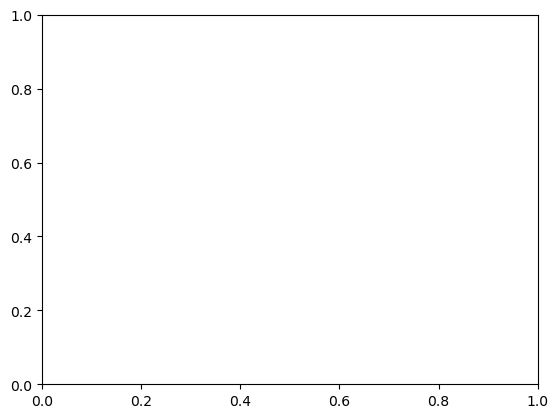

In [10]:
max_clusters = 201
test_acc = []
time_running = []
for i in range(1, max_clusters + 1, 5):
    start_time = time()
    cluster = ClusterRbf(train_data, train_labels, i)
    new_samples_train = cluster.transform_gauss(train_data)
    new_samples_test = cluster.transform_gauss(test_data)
    time_running.append(time() - start_time)
    print(f"{i}: Initialize and transform time = {time_running[-1]} seconds")
    
    X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
    
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)
    model = SimpleMLP((i*len(np.unique(train_labels))))
    print(f"===== {i} iteration =====") 
    test_acc.append(batch_gd(train_loader, test_loader, model, device, epoch_update=40))

plt.plot(range(1, max_clusters + 1), test_acc, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Clusters')
plt.ylabel('Test_Accuracies')
plt.show()

plt.plot(range(1, max_clusters + 1), time_running, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Clusters')
plt.ylabel('time')
plt.show()

    

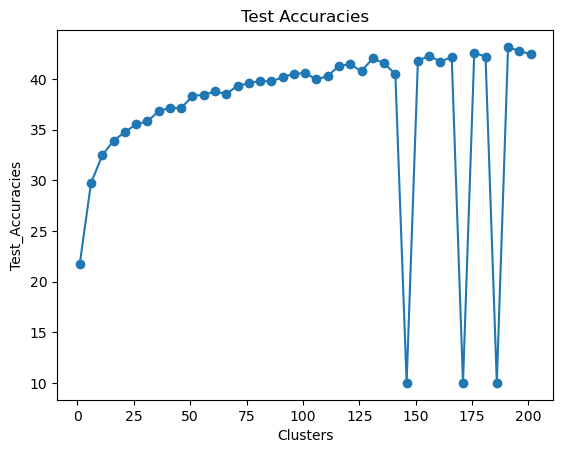

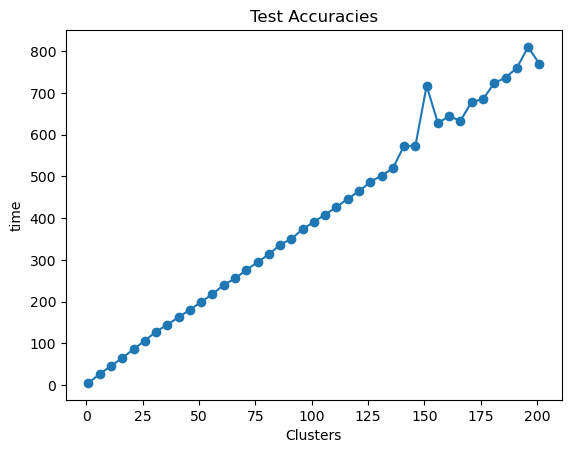

In [12]:
plt.plot(range(1, max_clusters + 1, 5), test_acc, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Clusters')
plt.ylabel('Test_Accuracies')
plt.show()

plt.plot(range(1, max_clusters + 1, 5), time_running, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Clusters')
plt.ylabel('time')
plt.show()

In [42]:
num_clusters = [100, 150]
dropout1 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
dropout2 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]

best_params = np.zeros((5, 1))
test_acc = 0
for clusters in num_clusters:
    start_time = time()
    cluster = ClusterRbf(train_data, train_labels, clusters)
    new_samples_train = cluster.transform_gauss(train_data)
    new_samples_test = cluster.transform_gauss(test_data)
    print(f"{i}: Initialize and transform time = {time() - start_time} seconds")
                
    X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
                
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)
    if clusters == 100:
        hid1 = 128
        hid2 = 256
    else:
        hid1 = 512
        hid2 = 1024
    for drop1 in dropout1:
        for drop2 in dropout2:
            if (clusters*len(np.unique(train_labels)) < hid1) or (clusters*len(np.unique(train_labels)) < hid2):
                 continue
            model = TripleMLP(clusters * len(np.unique(train_labels)), hid1, hid2, drop1, drop2)
            print(f"[ {clusters*len(np.unique(train_labels))}, {hid1}, {hid2}, {drop1}, {drop2}] clusters = {clusters}")
            testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)
            if testing > test_acc:
                test_acc = testing
                best_params[0] = clusters
                best_params[1] = hid1
                best_params[2] = hid2
                best_params[3] = drop1
                best_params[4] = drop2

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

201: Initialize and transform time = 402.97938776016235 seconds
[ 1000, 128, 256, 0.0, 0.0] clusters = 100
Epoch [40 / 40], loss 1.3841
Training Accuracy of the network: 51.826 %
Testing accuracy of the network: 47.52 %
[ 1000, 128, 256, 0.0, 0.1] clusters = 100
Epoch [40 / 40], loss 1.2956
Training Accuracy of the network: 49.536 %
Testing accuracy of the network: 45.56 %
[ 1000, 128, 256, 0.0, 0.2] clusters = 100
Epoch [40 / 40], loss 1.1098
Training Accuracy of the network: 50.182 %
Testing accuracy of the network: 45.45 %
[ 1000, 128, 256, 0.0, 0.3] clusters = 100
Epoch [40 / 40], loss 1.2177
Training Accuracy of the network: 48.03 %
Testing accuracy of the network: 43.76 %
[ 1000, 128, 256, 0.0, 0.4] clusters = 100
Epoch [40 / 40], loss 1.5151
Training Accuracy of the network: 52.784 %
Testing accuracy of the network: 47.65 %
[ 1000, 128, 256, 0.0, 0.5] clusters = 100
Epoch [40 / 40], loss 1.5250
Training Accuracy of the network: 50.782 %
Testing accuracy of the network: 46.55 %
[

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

201: Initialize and transform time = 597.0980088710785 seconds
[ 1500, 512, 1024, 0.0, 0.0] clusters = 150
Epoch [40 / 40], loss 1.2960
Training Accuracy of the network: 60.0 %
Testing accuracy of the network: 48.29 %
[ 1500, 512, 1024, 0.0, 0.1] clusters = 150
Epoch [40 / 40], loss 1.0115
Training Accuracy of the network: 59.344 %
Testing accuracy of the network: 48.3 %
[ 1500, 512, 1024, 0.0, 0.2] clusters = 150
Epoch [40 / 40], loss 1.2663
Training Accuracy of the network: 58.294 %
Testing accuracy of the network: 47.8 %
[ 1500, 512, 1024, 0.0, 0.3] clusters = 150
Epoch [40 / 40], loss 1.1025
Training Accuracy of the network: 58.456 %
Testing accuracy of the network: 48.4 %
[ 1500, 512, 1024, 0.0, 0.4] clusters = 150
Epoch [40 / 40], loss 1.2414
Training Accuracy of the network: 55.942 %
Testing accuracy of the network: 44.89 %
[ 1500, 512, 1024, 0.0, 0.5] clusters = 150
Epoch [40 / 40], loss 1.4424
Training Accuracy of the network: 59.09 %
Testing accuracy of the network: 48.58 %
[

In [23]:
for params in best_params: # clusters [50, 75, 100]
    print(params)

[100.]
[128.]
[256.]


In [40]:
for params in best_params: # clusters [100, 150]
    print(params)

[150.]
[512.]
[1024.]


In [43]:
for params in best_params:
    print(params)

[150.]
[512.]
[1024.]
[0.2]
[0.]


In [44]:
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 150)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"{i}: Initialize and transform time = {time() - start_time} seconds")
                
X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
                
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)
model = TripleMLP(150 * len(np.unique(train_labels)), 512, 1024, 0.2, 0.)
testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

201: Initialize and transform time = 586.5000586509705 seconds
Epoch [40 / 40], loss 1.0733
Training Accuracy of the network: 59.168 %
Testing accuracy of the network: 48.32 %


In [67]:
funcs = [Swish(), nn.ReLU(), nn.Sigmoid(), nn.LeakyReLU(), nn.GELU(), nn.PReLU(), nn.ELU(), nn.SELU(), nn.Softplus(), nn.Softsign(), nn.Tanh(), nn.Hardshrink(), nn.Hardtanh(), nn.ReLU6(), nn.SiLU(), Mish()]
testing = 0
best_func = None
learning_rate = 0.001
for func in funcs:
    model = TripleMLP(150 * len(np.unique(train_labels)), 512, 1024, 0.2, 0., func)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, mode='max')
    testing = batch_gd(train_loader, test_loader, model, device, optimizer, scheduler, epoch_update=40)
    if testing > test_acc:
        test_acc = testing
        best_func = func

Epoch [40 / 40], loss 1.7153
Training Accuracy of the network: 47.57 %
Testing accuracy of the network: 44.82 %
Epoch [40 / 40], loss 1.5031
Training Accuracy of the network: 51.074 %
Testing accuracy of the network: 45.16 %
Epoch [40 / 40], loss 1.7613
Training Accuracy of the network: 43.514 %
Testing accuracy of the network: 42.78 %
Epoch [40 / 40], loss 1.4344
Training Accuracy of the network: 50.622 %
Testing accuracy of the network: 44.42 %
Epoch [40 / 40], loss 1.4491
Training Accuracy of the network: 49.818 %
Testing accuracy of the network: 45.48 %
Epoch [40 / 40], loss 1.4182
Training Accuracy of the network: 54.158 %
Testing accuracy of the network: 44.25 %
Epoch [40 / 40], loss 1.6433
Training Accuracy of the network: 45.076 %
Testing accuracy of the network: 43.94 %
Epoch [40 / 40], loss 1.5368
Training Accuracy of the network: 43.44 %
Testing accuracy of the network: 42.21 %
Epoch [40 / 40], loss 1.6354
Training Accuracy of the network: 44.078 %
Testing accuracy of the ne

In [80]:
learning_rate = 0.001
model = TripleMLP(150 * len(np.unique(train_labels)), 512, 1024, 0.2, 0.)
testing = batch_gd(train_loader, test_loader, model, device, num_epochs=50, learning_rate=0.01)


Epoch [5 / 50], loss 1.7922
Training Accuracy of the network: 40.04 %
Testing accuracy of the network: 40.14 %
Epoch [10 / 50], loss 1.7534
Training Accuracy of the network: 43.366 %
Testing accuracy of the network: 42.11 %
Epoch [15 / 50], loss 1.4787
Training Accuracy of the network: 44.252 %
Testing accuracy of the network: 42.03 %
Epoch [20 / 50], loss 1.7385
Training Accuracy of the network: 45.452 %
Testing accuracy of the network: 43.44 %
Epoch [25 / 50], loss 1.5541
Training Accuracy of the network: 46.726 %
Testing accuracy of the network: 44.29 %
Epoch [30 / 50], loss 1.5763
Training Accuracy of the network: 47.368 %
Testing accuracy of the network: 43.54 %
Epoch [35 / 50], loss 1.5403
Training Accuracy of the network: 47.91 %
Testing accuracy of the network: 43.37 %
Epoch [40 / 50], loss 1.5463
Training Accuracy of the network: 49.072 %
Testing accuracy of the network: 44.33 %
Epoch [45 / 50], loss 1.6273
Training Accuracy of the network: 50.032 %
Testing accuracy of the net

In [12]:
class QuatroMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, dropout1=0., dropout2=0., dropout3=0.):
        super(QuatroMLP, self).__init__()
        self.linear = nn.Sequential(
            nn.Dropout(dropout1),
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),  # Call the activation function here
            nn.Dropout(dropout2),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),  # Call the activation function here
            nn.Dropout(dropout3),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.ReLU(),  # Call the activation function here
            nn.Linear(hidden_size3, 10)
        )

    def forward(self, x):
        return self.linear(x)

In [85]:
hidden_size1 = [1024, 512, 256, 128, 64]
hidden_size2 = [1024, 512, 256, 128, 64]
hidden_size3 = [1024, 512, 256, 128, 64]

test_acc = 0
best_params = np.zeros((3, 1))
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 150)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")
                
X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
                
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for hid1 in hidden_size1:
    for hid2 in hidden_size2:
        for hid3 in hidden_size3:
            model = QuatroMLP(150 * len(np.unique(train_labels)), hid1, hid2, hid3)
            print(f"[ {clusters*len(np.unique(train_labels))}, {hid1}, {hid2}, {hid3}] clusters = 150")
            testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)
            if testing > test_acc:
                test_acc = testing
                best_params[0] = hid1
                best_params[1] = hid2
                best_params[2] = hid3

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

KeyboardInterrupt: 

In [13]:
class AE(nn.Module):
    def __init__(self, input_size):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [93]:
cluster = ClusterRbf(train_data, train_labels, 120)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

batch_size=256
X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
                
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 2401.0629739761353 seconds


In [24]:
batch_size = 256

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_data, train_labels = next(iter(train))
train_data = np.array(train_data).reshape(-1, 3*32*32)
train_data = train_data / 255.0
train_labels = np.array(train_labels).astype(int)

test_data, test_labels = next(iter(test))
test_data = np.array(test_data).reshape(-1, 3*32*32)
test_data = test_data / 255.0
test_labels = np.array(test_labels).astype(int)
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size = 256
X_train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)
                
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)


In [26]:
model = AE(3*32*32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_gdAE(model, criterion, optimizer, train_loader, n_epochs=10, device=device)

 10%|████████▎                                                                          | 1/10 [00:01<00:17,  1.93s/it]

Epoch  0  loss =  1.210991554751672


 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.89s/it]

Epoch  1  loss =  0.007085354141963762


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.87s/it]

Epoch  2  loss =  0.003327797299789381


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.87s/it]

Epoch  3  loss =  0.001866613681158924


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.86s/it]

Epoch  4  loss =  0.001161313547527243


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.87s/it]

Epoch  5  loss =  0.0007846935811812727


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.86s/it]

Epoch  6  loss =  0.0005611848343960446


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:14<00:03,  1.86s/it]

Epoch  7  loss =  0.0004244165000955036


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:16<00:01,  1.89s/it]

Epoch  8  loss =  0.00033663134058770083


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]

Epoch  9  loss =  0.0002765890744740318


In [27]:
pca = PCA(0.9, random_state=42).fit(train_data)
print(f"PCA is complete with {pca.n_components_} components")
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

PCA is complete with 99 components


In [161]:
hidden_size1 = [1024, 512, 256, 128, 64]
hidden_size2 = [1024, 512, 256, 128, 64]
hidden_size3 = [1024, 512, 256, 128, 64]

test_acc = 0
best_params = np.zeros((6, 1))
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 150)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for hid1 in hidden_size1:
    for hid2 in hidden_size2:
        for hid3 in hidden_size3:
            model = QuatroMLP(150 * len(np.unique(train_labels)), hid1, hid2, hid3)
            print(f"[ {150*len(np.unique(train_labels))}, {hid1}, {hid2}, {hid3}] clusters = 150")
            testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)
            if testing > test_acc:
                test_acc = testing
                best_params[0] = hid1
                best_params[1] = hid2
                best_params[2] = hid3

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 617.6893126964569 seconds
[ 1500, 1024, 1024, 1024] clusters = 150
Epoch [40 / 40], loss 0.9427
Training Accuracy of the network: 73.916 %
Testing accuracy of the network: 47.75 %
[ 1500, 1024, 1024, 512] clusters = 150
Epoch [40 / 40], loss 1.0159
Training Accuracy of the network: 66.19 %
Testing accuracy of the network: 46.06 %
[ 1500, 1024, 1024, 256] clusters = 150
Epoch [40 / 40], loss 0.9334
Training Accuracy of the network: 67.402 %
Testing accuracy of the network: 48.07 %
[ 1500, 1024, 1024, 128] clusters = 150
Epoch [40 / 40], loss 1.1190
Training Accuracy of the network: 59.138 %
Testing accuracy of the network: 45.35 %
[ 1500, 1024, 1024, 64] clusters = 150
Epoch [40 / 40], loss 1.1850
Training Accuracy of the network: 61.468 %
Testing accuracy of the network: 48.44 %
[ 1500, 1024, 512, 1024] clusters = 150
Epoch [40 / 40], loss 0.9957
Training Accuracy of the network: 68.48 %
Testing accuracy of the network: 47.56 %
[ 1500, 1024, 512, 512] cl

In [29]:
for param in best_params:
    print(param)

[1024.]
[512.]
[64.]
[0.]
[0.]
[0.]


In [30]:
dropout1 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
dropout2 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]
dropout3 = [0., 0.1, 0.2, 0.3, 0.4, 0.5]

test_acc = 0
start_time = time()
cluster = ClusterRbf(train_data, train_labels, 150)
new_samples_train = cluster.transform_gauss(train_data)
new_samples_test = cluster.transform_gauss(test_data)
print(f"Initialize and transform time = {time() - start_time} seconds")

X_train_tensor = torch.tensor(new_samples_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(new_samples_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

for drop1 in dropout1:
    for drop2 in dropout2:
        for drop3 in dropout3:
            model = QuatroMLP(input_size=150 * len(np.unique(train_labels)), hidden_size1=1024, hidden_size2=512, hidden_size3=64, dropout1=drop1, dropout2=drop2, dropout3=drop3)
            print(f"[ {150*len(np.unique(train_labels))}, {1024}, {512}, {64}, {drop1}, {drop2}, {drop3}] clusters = 150")
            testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)
            if testing > test_acc:
                test_acc = testing
                best_params[3] = drop1
                best_params[4] = drop2
                best_params[5] = drop3

C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\envs\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

Initialize and transform time = 600.3820748329163 seconds
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.0] clusters = 150
Epoch [40 / 40], loss 1.1540
Training Accuracy of the network: 58.436 %
Testing accuracy of the network: 47.06 %
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.1] clusters = 150
Epoch [40 / 40], loss 1.4411
Training Accuracy of the network: 56.992 %
Testing accuracy of the network: 48.49 %
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.2] clusters = 150
Epoch [40 / 40], loss 1.3208
Training Accuracy of the network: 56.682 %
Testing accuracy of the network: 49.39 %
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.3] clusters = 150
Epoch [40 / 40], loss 1.5638
Training Accuracy of the network: 54.896 %
Testing accuracy of the network: 49.47 %
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.4] clusters = 150
Epoch [40 / 40], loss 1.5025
Training Accuracy of the network: 52.29 %
Testing accuracy of the network: 47.78 %
[ 1500, 1024, 512, 64, 0.0, 0.0, 0.5] clusters = 150
Epoch [40 / 40], loss 1.3784
Training Accuracy of the networ

In [32]:
for param in best_params:
    print(param)

[1024.]
[512.]
[64.]
[0.]
[0.1]
[0.3]


In [36]:
model = QuatroMLP(input_size=1500, hidden_size1=1024, hidden_size2=512, hidden_size3=64, dropout1=0., dropout2=0.1, dropout3=0.3)
model=model.to(device)
testing = batch_gd(train_loader, test_loader, model, device)

Epoch [5 / 40], loss 1.7124
Training Accuracy of the network: 42.022 %
Testing accuracy of the network: 41.93 %
Epoch [10 / 40], loss 1.3537
Training Accuracy of the network: 45.152 %
Testing accuracy of the network: 43.78 %
Epoch [15 / 40], loss 1.6250
Training Accuracy of the network: 46.508 %
Testing accuracy of the network: 45.11 %
Epoch [20 / 40], loss 1.4670
Training Accuracy of the network: 48.15 %
Testing accuracy of the network: 46.57 %
Epoch [25 / 40], loss 1.2964
Training Accuracy of the network: 48.67 %
Testing accuracy of the network: 46.6 %
Epoch [30 / 40], loss 1.3522
Training Accuracy of the network: 50.318 %
Testing accuracy of the network: 47.18 %
Epoch [35 / 40], loss 1.4474
Training Accuracy of the network: 49.9 %
Testing accuracy of the network: 47.25 %
Epoch [40 / 40], loss 1.4285
Training Accuracy of the network: 53.37 %
Testing accuracy of the network: 49.16 %


In [68]:
def majority_vote(predictions, num_classes=10):
    class_votes = np.zeros((len(predictions), 1))
    for i, prediction in enumerate(predictions):
        element_counts = Counter(prediction)
        most_common_element = element_counts.most_common(1)[0][0]
        class_votes[i] = most_common_element
    return class_votes


In [42]:
t0=time()
models = []

for i in range(30):
    print("----------Model", (i+1), "----------")

    model = QuatroMLP(input_size=1500, hidden_size1=1024, hidden_size2=512, hidden_size3=64, dropout1=0., dropout2=0.1, dropout3=0.3)  # Create and compile your CNN model
    model = model.to(device)

    testing = batch_gd(train_loader, test_loader, model, device, epoch_update=40)

    models.append(model)
    model.eval()
print(f"Elapsed Time: {(time() - t0):.3f} seconds")

----------Model 1 ----------
Epoch [40 / 40], loss 1.7690
Training Accuracy of the network: 53.566 %
Testing accuracy of the network: 49.14 %
----------Model 2 ----------
Epoch [40 / 40], loss 1.2822
Training Accuracy of the network: 53.184 %
Testing accuracy of the network: 48.39 %
----------Model 3 ----------
Epoch [40 / 40], loss 1.4917
Training Accuracy of the network: 52.766 %
Testing accuracy of the network: 48.19 %
----------Model 4 ----------
Epoch [40 / 40], loss 1.5403
Training Accuracy of the network: 53.028 %
Testing accuracy of the network: 48.61 %
----------Model 5 ----------
Epoch [40 / 40], loss 1.3754
Training Accuracy of the network: 52.66 %
Testing accuracy of the network: 48.15 %
----------Model 6 ----------
Epoch [40 / 40], loss 1.4009
Training Accuracy of the network: 52.69 %
Testing accuracy of the network: 48.56 %
----------Model 7 ----------
Epoch [40 / 40], loss 1.3716
Training Accuracy of the network: 52.668 %
Testing accuracy of the network: 48.41 %
--------

In [78]:
all_predictions = []

with torch.no_grad():
    for model in models:
        model_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            model_predictions.extend(predicted.cpu().numpy())

        all_predictions.append(model_predictions)

predictions_matrix = np.column_stack(all_predictions)

final_predictions = majority_vote(predictions_matrix)
final_predictions_flat = final_predictions.flatten()
samples = len(final_predictions_flat)  
correct = (final_predictions_flat == test_labels).sum()  
print(f"Total Accuracy: {100 * accuracy:.4f} %")


(10000, 1)
(10000,)
Total Accuracy: 51.2100 %
